In [1]:
from IPython.display import clear_output

In [2]:
# %pip install torch torchvision
# %pip install numpy
# %pip install scikit-learn
# %pip install matplotlib
# %pip install tqdm

clear_output()

## Contents

In this notebook, we will take a look at dimensionality reduction algorithms.

We will implement the Principal Component Analysis(PCA) algorithm ourselves, and use the SKlearn's implementation of TSNE algorithm.

To demonstrate the algorithm, we will use a pre-trained image classifier model(VGG) to extract embeddings of some images, reduce the embeddings using PCA and the find similar images using the reduced embeddings.

For the images, we will use Caltech-101 object categories dataset because of the high quality of images.

In [13]:
import random

import numpy as np

import torch
from torch.utils.data import DataLoader, Subset

import torchvision
import torchvision.transforms as transforms
from torchvision import models

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.manifold import TSNE

import matplotlib.pyplot as plt

from tqdm import tqdm

In [4]:
# For reproducable results. Can be skipped/commented.
torch.manual_seed(7)
random.seed(7)

## Downloading and Loading Images

In [5]:
!echo "Downloading 101_Object_Categories for image notebooks"

!curl -L -o 101_ObjectCategories.zip --progress-bar https://data.caltech.edu/records/mzrjq-6wc02/files/caltech-101.zip?download=1
!unzip 101_ObjectCategories.zip
!mv caltech-101/101_ObjectCategories.tar.gz ./101_ObjectCategories.tar.gz
!tar -xzf 101_ObjectCategories.tar.gz
!rm 101_ObjectCategories.tar.gz
!ls

############################################################################################# 100.0%
Archive:  101_ObjectCategories.zip
   creating: caltech-101/
  inflating: __MACOSX/._caltech-101  
  inflating: caltech-101/101_ObjectCategories.tar.gz  
  inflating: __MACOSX/caltech-101/._101_ObjectCategories.tar.gz  
  inflating: caltech-101/show_annotation.m  
  inflating: __MACOSX/caltech-101/._show_annotation.m  
  inflating: caltech-101/Annotations.tar  
  inflating: __MACOSX/caltech-101/._Annotations.tar  
101_ObjectCategories  101_ObjectCategories.zip	caltech-101  __MACOSX  sample_data


In [6]:
batch_size = 64  # for batched. feature extraction
n_images = 1000  # num images to keep in the dataset.

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [7]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# image_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)  # dataset can be replaced with CIFAR10
image_dataset = torchvision.datasets.ImageFolder(root='101_ObjectCategories', transform=transform)
random_indices = random.sample(range(len(image_dataset)), n_images)
images_subset = Subset(image_dataset, random_indices)

image_loader = DataLoader(images_subset, batch_size, shuffle=False, num_workers=2)

## Downloading and Loading model

In [8]:
vgg16 = models.vgg16(pretrained=True)
vgg16.eval().to(device)


def extract_features(image_tensor: torch.Tensor):

    image_tensor = image_tensor.to(device)

    # Dont need to compute gradients because we're not training the model. It's pre-trained
    # We're passing by each layer manually because we don't want to pass the data through the ENTIRE model.
    # We wanna skip the last one or 2 layers so we don't get class probabilities (incase of classifier model) but the features representing the images
    with torch.no_grad():
        features = vgg16.features(image_tensor)
        features = features.view(features.size(0), -1)
        features = vgg16.classifier[0](features)
        features = vgg16.classifier[1](features)
        features = vgg16.classifier[2](features)

    return features

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:05<00:00, 101MB/s] 


## Extracting model features for all images

In [9]:
all_features = torch.Tensor().to(device)
image_tensors = torch.Tensor()  # No need to push this to device. We wanna keep this on CPU

for image_batch, _ in tqdm(image_loader):

    image_tensors = torch.cat((image_tensors, image_batch), dim=0)

    batch_features = extract_features(image_batch)
    all_features = torch.cat((all_features, batch_features), dim=0)

all_features = all_features.cpu().numpy()  # need numpy for PCA. need cpu for numpy.

print('')  # empty line
print(f'{image_tensors.shape=}')
print(f'{all_features.shape=}')

100%|██████████| 16/16 [00:07<00:00,  2.05it/s]


image_tensors.shape=torch.Size([1000, 3, 224, 224])
all_features.shape=(1000, 4096)


## Implementing PCA

In [10]:
def pca(X, n_components):

    # Standardize the data(zero mean and unit variance)
    X_meaned = X - np.mean(X, axis=0)

    # Compute the covariance matrix
    cov_matrix = np.cov(X_meaned, rowvar=False)

    # Compute the eigenvalues and eigenvectors
    eigenvalues, eigenvectors = np.linalg.eigh(cov_matrix)

    # Sort the eigenvalues and corresponding eigenvectors in descending order
    sorted_index = np.argsort(eigenvalues)[::-1]
    sorted_eigenvalues = eigenvalues[sorted_index]
    sorted_eigenvectors = eigenvectors[:, sorted_index]

    # Select the top n_components eigenvectors
    eigenvector_subset = sorted_eigenvectors[:, 0:n_components]

    # Transform the data
    X_reduced = np.dot(X_meaned, eigenvector_subset)

    return X_reduced, sorted_eigenvalues, sorted_eigenvectors

## Extracting PCA features

In [11]:
n_pca_components = 300  # hyper param for number of top params to keep after PCA

pca_features, sorted_eigenvalues, sorted_eigenvectors = pca(all_features, n_pca_components)

print(f'{pca_features.shape=}')  # batch size should be same but embedding size should be reduced to n_pca_components

pca_features.shape=(1000, 300)


## Let's get to image searching

Now that we have PCA features, let's use them for finding similar images.

1. Take a random image from the dataset
2. Find top n most similar images to it. Use the similarity of PCA features to find the similar images

you can rerun this cell multiple times for different random results

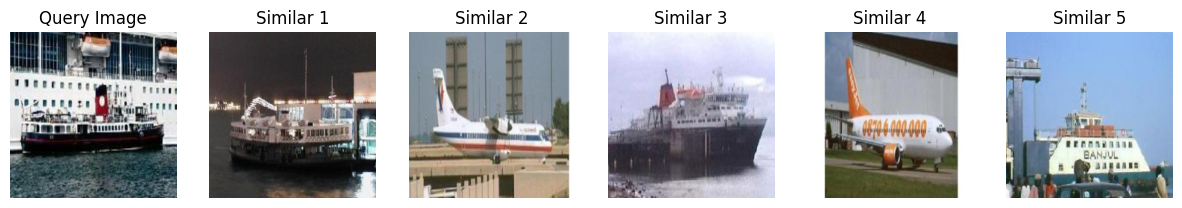

In [12]:
random_image_index = random.randint(0, len(pca_features) - 1)
random_image = image_tensors[random_image_index]
image_features = pca_features[random_image_index]

cosine_similarities = cosine_similarity(pca_features, image_features.reshape(1, -1)).reshape(-1)

# "::-1" because we want descending cosine similarity indexes and argsort defaults to ascending
# "1:6" instead of "0:5" because the first image(most similar) would be the query image itself.
similar_indices = cosine_similarities.argsort()[::-1][1:6]

# Display the images
plt.figure(figsize=(15, 3))
plt.subplot(1, 6, 1)
plt.imshow(random_image.squeeze().permute(1, 2, 0).numpy())
plt.title('Query Image')
plt.axis('off')

for i, idx in enumerate(similar_indices):
    image = image_tensors[idx]
    plt.subplot(1, 6, i + 2)
    plt.imshow(image.squeeze().permute(1, 2, 0).numpy())
    plt.title(f'Similar {i+1}')
    plt.axis('off')

plt.show()

## Let's Try with TSNE

In [15]:
n_tsne_components = 3
tsne = TSNE(n_components=n_tsne_components, learning_rate='auto', init='random', perplexity=3)
tsne_features = tsne.fit_transform(all_features)

print(f'{tsne_features.shape=}')  # batch size should be same but embedding size should be reduced to n_pca_components

tsne_features.shape=(1000, 3)


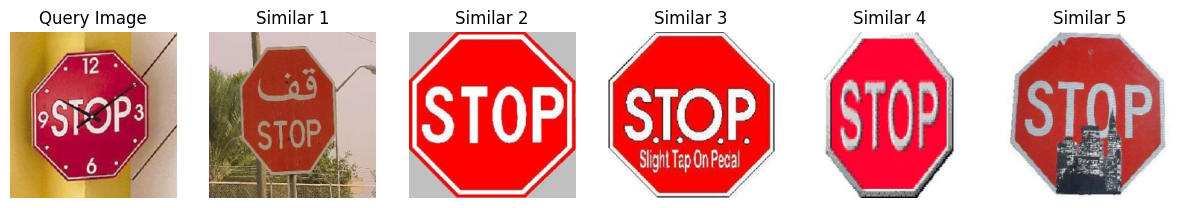

In [16]:
random_image_index = random.randint(0, len(tsne_features) - 1)
random_image = image_tensors[random_image_index]
image_features = tsne_features[random_image_index]

cosine_similarities = cosine_similarity(tsne_features, image_features.reshape(1, -1)).reshape(-1)

# "::-1" because we want descending cosine similarity indexes and argsort defaults to ascending
# "1:6" instead of "0:5" because the first image(most similar) would be the query image itself.
similar_indices = cosine_similarities.argsort()[::-1][1:6]

# Display the images
plt.figure(figsize=(15, 3))
plt.subplot(1, 6, 1)
plt.imshow(random_image.squeeze().permute(1, 2, 0).numpy())
plt.title('Query Image')
plt.axis('off')

for i, idx in enumerate(similar_indices):
    image = image_tensors[idx]
    plt.subplot(1, 6, i + 2)
    plt.imshow(image.squeeze().permute(1, 2, 0).numpy())
    plt.title(f'Similar {i+1}')
    plt.axis('off')

plt.show()

## Let's Visualize TSNE features

In [29]:
visualization_features = tsne_features[similar_indices.tolist()
                                +np.random.randint(0, len(tsne_features)-1, 5).tolist()]  # 5 similar images and 5 random images

In [30]:
visualization_features.shape

(10, 3)

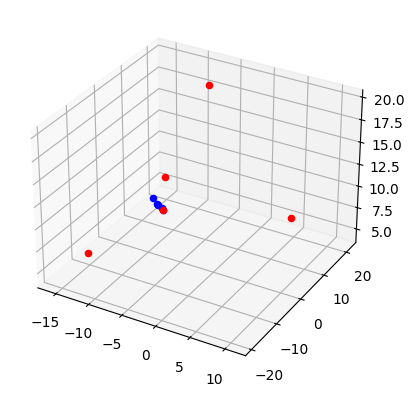

In [31]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

for i, features in enumerate(visualization_features):
    color = 'b' if i < 5 else 'r'  # b for similar indices
    ax.scatter(features[0], features[1], features[2], c=color)

plt.show()